In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
seq_dim=(6,6)

In [14]:

seq = np.load("seq.npy")
seq_t = np.load("seq_t.npy")
t = np.load("t.npy")
print(t.min(), t.max())
print(seq_t.min(), seq_t.max())

1.5 11.869565
0.5 10.869565


Text(0, 0.5, '$\\alpha$-1')

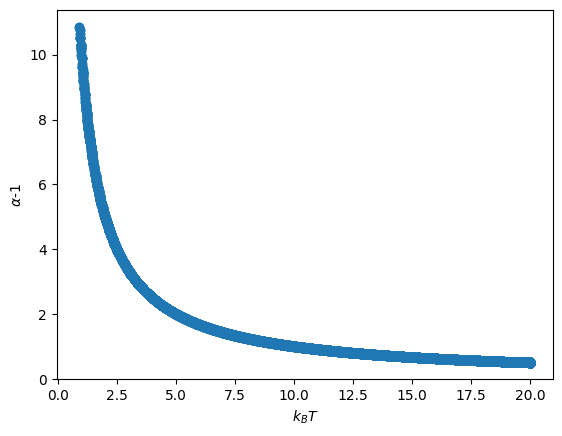

In [6]:
plt.scatter(10./seq_t,seq_t)
# plt.axvline(3)
plt.xlabel("$k_BT$")
plt.ylabel(r"$\alpha$-1")

Text(0.5, 0, '$k_BT$')

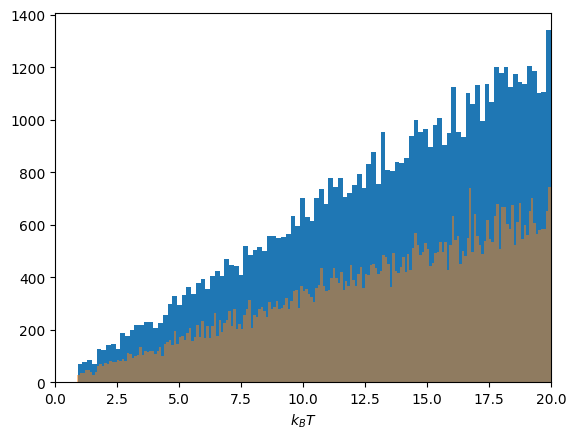

In [7]:
plt.hist(10./seq_t,bins=100)
plt.hist(10./(t-1),bins=200, alpha=0.5, range=(0,20))
plt.xlim((0, 20))
# plt.axvline(3, c="k")
plt.xlabel("$k_BT$")


Text(0.5, 0, '$\\alpha$-1')

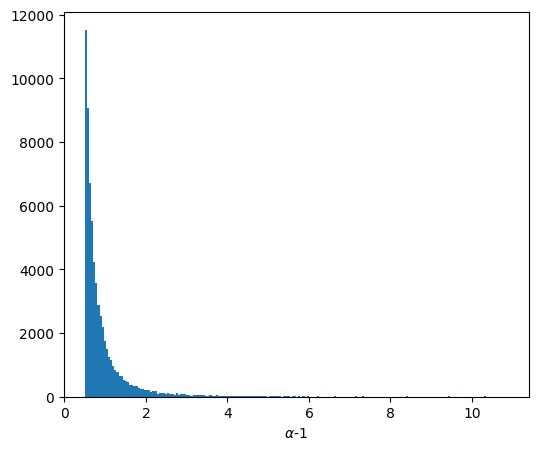

In [15]:
plt.hist(t-1,bins=200)
plt.xlabel(r"$\alpha$-1")

In [4]:
rc_logits = np.load("rc_logits.npy")
rc_seq = np.load("rc_seq.npy")
rc_loss = np.load("rc_loss.npy").reshape(100,-1).mean(axis=-1)

In [11]:
print(rc_logits.shape, rc_loss.shape)

(100, 37) (100,)


/tmp/ipykernel_980484/405704026.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xgrid, -np.log(rc_seq[i]), c=line_color[i], marker="x")
/tmp/ipykernel_980484/405704026.py:7: RuntimeWarning: divide by zero encountered in log
  plt.plot(xgrid, -np.log(rc_logits[i]), c=line_color[i], label="$k_BT$=%f, t=%f"%(10./(ii+1e-4), ii))
/tmp/ipykernel_980484/405704026.py:8: RuntimeWarning: divide by zero encountered in log
  plt.scatter(xgrid, -np.log(rc_seq[i]), c=line_color[i], marker="x")


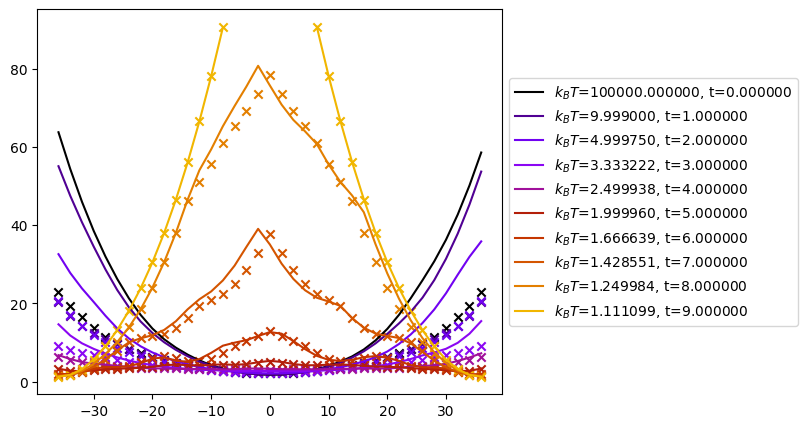

In [13]:
line_color = [plt.colormaps["gnuplot"](float(i)/float(101)) for i in range(101)]
xgrid = np.linspace(-36, 36, 36+1)
plt.rcParams["figure.figsize"] = (6,5)
plt.figure()
for i in range(0, 100, 10):
    ii = i/10.
    plt.plot(xgrid, -np.log(rc_logits[i]), c=line_color[i], label="$k_BT$=%f, t=%f"%(10./(ii+1e-4), ii))
    plt.scatter(xgrid, -np.log(rc_seq[i]), c=line_color[i], marker="x")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


(10,) (10, 37)


Text(0.5, 0, '$\\alpha$-1')

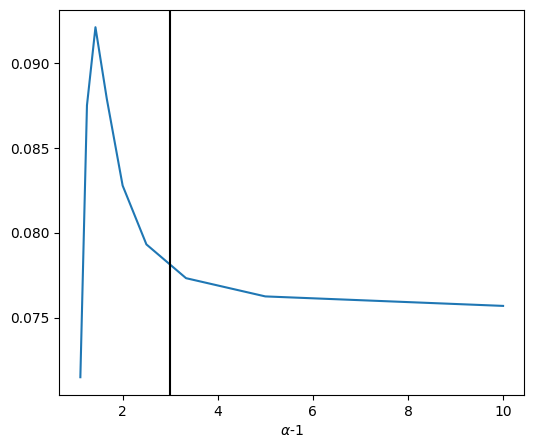

In [12]:
print(rc_loss.shape, rc_logits.shape)
plt.plot(10./np.arange(1,10), rc_loss[1:])
plt.axvline(3, c="k")
plt.xlabel(r"$\alpha$-1")

Text(0.5, 0, '$k_BT$')

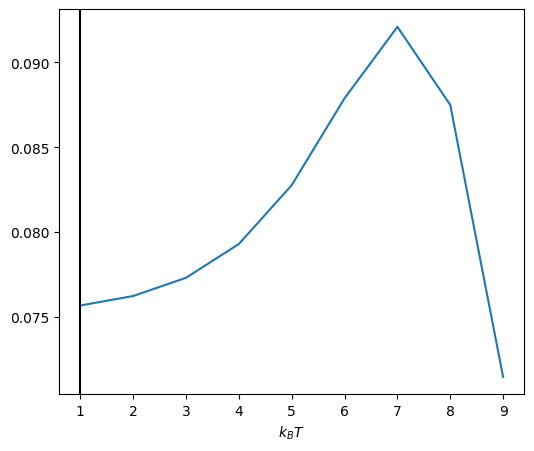

In [13]:
plt.plot(10/(10./np.arange(1,10)), rc_loss[1:])
plt.axvline(1, c="k")
plt.xlabel(r"$k_BT$")

In [ ]:
import torch

# seq_onehot = torch.nn.functional.one_hot(torch.from_numpy(seq).reshape(-1), num_classes=2).reshape(*seq.shape, 2)
def RC(logits):
    assert logits.shape[-1] == 2
    B = logits.shape[0]
    RC = torch.sum(logits*torch.tensor([-1,1], device=logits.device)[None,None,None,:], dim=-1)
    RC = torch.sum(RC.reshape(B, -1), dim=-1)
    return RC.reshape(-1)

In [ ]:
def plot_magn(t, epoch=397):
    logits = np.load("logs-dir-ising/latt6x6_e/finetune1/val_baseline_latt6x6/epoch%d_sample1/logits_val_inttime%s.npy"%(epoch, t))
    norm_logits = torch.nn.functional.softmax(torch.from_numpy(logits), dim=-1)
    xt = np.load("logs-dir-ising/latt6x6_e/finetune1/val_baseline_latt6x6/epoch%d_sample1/xt_val_inttime%s.npy"%(epoch, t))
    rc = RC(torch.from_numpy(logits))
    rc_norm = RC(norm_logits)
    rc_xt = RC(torch.from_numpy(xt))
    seq = np.argmax(logits, axis=-1).reshape(-1,np.prod(seq_dim))
    seq[np.where(seq==0)]=-1
    magn = np.sum(seq, axis=-1)
    
    plt.rcParams["figure.figsize"] = (22,5)
    plt.figure()
    plt.subplot(141)
    plt.hist(rc, bins=100)
    plt.xlim((-36,36))
    plt.title("RC(logits), $k_BT$=%f"%(10./(float(t)-1+1e-5)))
    plt.subplot(142)
    plt.hist(rc_xt,bins=100)
    plt.xlim((-36,36))
    plt.title("RC(xt), $k_BT$=%f"%(10./(float(t)-1+1e-5)))
    plt.subplot(143)
    plt.hist(magn,bins=100)
    plt.xlim((-36,36))
    plt.title("RC(argmax(logits)), $k_BT$=%f"%(10./(float(t)-1+1e-5)))
    plt.subplot(144)
    plt.hist(rc_norm,bins=100)
    plt.xlim((-36,36))
    plt.title("RC(logits/|logits|)), $k_BT$=%f"%(10./(float(t)-1+1e-5)))

In [ ]:
for t in ['4.41', '4.77', '5.13', '5.49', '5.85']:
    plot_magn(t)

In [ ]:
raise RuntimeError
def kde_2d(t, rc_trajs, x_grid, bandwidth=2., stage="train"):
    """
    Kernel Density Estimation (KDE) using a Gaussian kernel.
    Parameters:
    - data: Tensor containing the data points (1-dimensional).
    - x_grid: Tensor containing the grid points for which to compute the KDE.
    - bandwidth: Bandwidth parameter for the Gaussian kernel (default=0.5).
    Returns:
    - Tensor of shape (len(x_grid),) containing the estimated density values.
    """
    # Initialize density estimates
    B = rc_trajs.shape[0]
    density = torch.zeros(*x_grid.shape[:-1], device=rc_trajs.device)
    # Compute KDE
    '''
    for ii in range(x_grid.shape[0]):
        for jj in range(x_grid.shape[1]):
            x = x_grid[ii][jj]
            # Kernel function (Gaussian kernel)
            kernel = torch.exp(-0.5 * ((rc_trajs - x[0]) / bandwidth)**2 -0.5 * ((t-x[1]) / bandwidth)**2) / 2 * torch.tensor(3.141592653589793)
            # Sum over all data points
            density[ii,jj] = torch.sum(kernel) / (bandwidth * 2 * torch.tensor(3.141592653589793))
            print(ii,jj)
    '''
    print((rc_trajs[:,None,None]-x_grid[None,:,:,0]).shape)
    print((t[:,None,None]-x_grid[None,:,:,1]).shape)
    
    kernel = torch.exp(-0.5*((rc_trajs[:,None,None]-x_grid[None,:,:,0])/bandwidth )**2 -0.5*((t[:,None,None]-x_grid[None,:,:,1])/bandwidth )**2 ) /2 *torch.pi
    density = torch.sum(kernel, dim=0)
    norm_density = density/density.sum(dim=0)[None,:]
    return norm_density

In [ ]:
x = scipy.stats.expon().rvs(size=1000)*2
plt.hist(x,bins=140,density=True)

In [ ]:
t = []
ii_list = [1.0, 1.1, 1.2, 1.4, 1.6, 1.8, 2.2, 2.8, 4.0, 4.8, 6.0]
for ii in ii_list:
    t.append(10./ii)
    print(1/ii*10, ii)
plt.plot(t, ii_list, marker="x")
plt.scatter(t, np.zeros(len(ii_list)))
plt.xlabel("Diffusion step")
plt.ylabel("$k_BT$")

In [ ]:
t_increment = np.random.uniform(size=1024)
t_increment = (t_increment-1.)*(10./6.-0.0001)
t = 10./6.+t_increment
plt.hist(t, bins=20)

In [ ]:

import torch
def RC(logits):
    assert logits.shape[-1] == 2
    B = logits.shape[0]
    RC = torch.sum(logits*torch.tensor([-1,1])[None,None,None,:], dim=-1)
    RC = torch.sum(RC.reshape(B, -1), dim=-1)
    return RC.reshape(-1,1)

def kde(rc_trajs, x_grid, bandwidth=2.):
        """
        Kernel Density Estimation (KDE) using a Gaussian kernel.

        Parameters:
        - data: Tensor containing the data points (1-dimensional).
        - x_grid: Tensor containing the grid points for which to compute the KDE.
        - bandwidth: Bandwidth parameter for the Gaussian kernel (default=0.5).

        Returns:
        - Tensor of shape (len(x_grid),) containing the estimated density values.
        """
        # Initialize density estimates
        B = rc_trajs.shape[0]
        density = torch.zeros([B, *x_grid.shape])
        # np.savetxt("rc-logits_train.dat", rc_trajs, delimiter=" ")
        # Compute KDE

        for i, x in enumerate(x_grid):
            # Kernel function (Gaussian kernel)
            kernel = torch.exp(-0.5 * ((rc_trajs.to(torch.float64) - x) / bandwidth)**2) / torch.sqrt(2 * torch.tensor(3.141592653589793))
            # Sum over all data points
            density[:,i] = torch.sum(kernel, axis=1) / (bandwidth * torch.sqrt(2 * torch.tensor(3.141592653589793)))

        sum_density = torch.sum(density, axis=1)
        norm_density = density/sum_density[:,None]
        F = -torch.log(norm_density)
        return norm_density

In [ ]:

import os, glob
import scipy
import matplotlib.pyplot as plt
seq_dim=(6,6)

# Evaluation at epoch 255

In [ ]:
# work_dir = "logs-dir-ising/latt6x6T2.0/kernel3x3_timeembed/finetune9/val_baseline_latt6x6/epoch170_sampletest"
work_dir = "logs-dir-ising/latt6x6_b/finetune25/val_baseline_latt6x6/epoch232_sample1"

In [ ]:
logits_files = sorted(glob.glob(os.path.join(work_dir, f"logits_val_step0_inttime*")))
t_span = [float(x.replace(os.path.join(work_dir, f"logits_val_step0_inttime"),"").replace(".npy","")) for x in logits_files]
print(t_span)
print([t_span[i]-t_span[i-1] for i in range(1,len(t_span))])
print(len(t_span))
num_integration_step = len(t_span)
xt = np.zeros([num_integration_step, 32768, 6, 6, 2])
logits = np.zeros([num_integration_step, 32768, 6, 6, 2])

In [ ]:
plt.plot(t_span, marker="x")

In [ ]:
import seaborn as sns
line_color = [plt.colormaps["gnuplot"](float(i)/float(num_integration_step)) for i in range(num_integration_step)]
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(12, 18))
for ii in range(num_integration_step):
    print(ii, t_span[ii])
    xt[ii] = np.load(glob.glob(os.path.join(work_dir, f"xt_val_step{0}_inttime{t_span[ii]}*"))[0])
    logits[ii] = np.load(glob.glob(os.path.join(work_dir, f"logits_val_step{0}_inttime{t_span[ii]}*"))[0])
    B = xt[ii].shape[0]

    rc=np.linspace(-36, 36, 36+1)
    rc_logits_here = kde(RC(torch.from_numpy(logits[ii])), torch.from_numpy(rc), 1.).numpy()
    rc_xt_here = kde(RC(torch.from_numpy(xt[ii])), torch.from_numpy(rc), 1.).numpy()
    rcmagn_here = np.sum(np.dot(rc_logits_here,rc).reshape(B,-1), axis=-1)
    rcmagn_xt_here = np.sum(np.dot(rc_xt_here,rc).reshape(B,-1), axis=-1)

    magn_here = np.sum(np.dot(logits[ii],np.array([-1,1])).reshape(B,-1), axis=-1)
    magn_xt_here = np.sum(np.dot(xt[ii],np.array([-1,1])).reshape(B,-1), axis=-1)

    seq_here = np.argmax(logits[ii].reshape(-1,2), axis=-1).reshape([B,-1])
    seq_here[np.where(seq_here == 0)] = -1
    magn_seq_here = np.sum(seq_here, axis=-1)
    seq_xt_here = np.argmax(xt[ii].reshape(-1,2), axis=-1).reshape([B,-1])
    seq_xt_here[np.where(seq_xt_here==0)] = -1
    magn_seq_xt_here = np.sum(seq_xt_here, axis=-1)

    # axes[0][0].hist2d(np.ones(B)*t_span[ii], magn_here, range=[[1., 8.], [-36., 36.]])
    # axes[0][1].hist2d(np.ones(B)*t_span[ii], magn_xt_here, range=[[1., 8.], [-36., 36.]])
    # # axes[0].set_ylim((-40,40))
    # axes[1][0].hist2d(np.ones(B)*t_span[ii], rcmagn_here, range=[[1., 8.], [-36., 36.]])
    # axes[1][1].hist2d(np.ones(B)*t_span[ii], rcmagn_xt_here, range=[[1., 8.], [-36., 36.]])
    sns.kdeplot(magn_here, ax=axes[0][0], color=line_color[ii])
    sns.kdeplot(magn_xt_here, ax=axes[0][1], color=line_color[ii])
    sns.kdeplot(rcmagn_here, ax=axes[1][0], color=line_color[ii])
    sns.kdeplot(rcmagn_xt_here, ax=axes[1][1], color=line_color[ii])
    sns.kdeplot(magn_seq_here, ax=axes[2][0], color=line_color[ii])
    sns.kdeplot(magn_seq_xt_here, ax=axes[2][1], color=line_color[ii])

axes[0][0].set_title("<m> from sum(model output logits)")
axes[0][0].set_xlabel("<m> of model output logits")
axes[0][1].set_title("<m> from sum(flow end)")
axes[0][1].set_xlabel("<m> of flow end")

axes[1][0].set_title("<m> from kde(RC(model output logits))")
axes[1][0].set_xlabel("<m> of model output logits")
axes[1][1].set_title("<m> from kde(RC(flow end))")
axes[1][1].set_xlabel("<m> of flow end")

axes[2][0].set_title("<m> from sum(argmax(model output logits))")
axes[2][0].set_xlabel("<m> of argmax(model output logits)")
axes[2][0].set_ylim((None, 0.1))
axes[2][1].set_title("<m> from sum(argmax(flow end))")
axes[2][1].set_xlabel("<m> of argmax(flow end)")

# At epoch 255

In [ ]:

# work_dir = "logs-dir-ising/latt6x6T2.0/kernel3x3_timeembed/finetune9/val_baseline_latt6x6/epoch170_sampletest"

In [ ]:
xt_a = np.load(os.path.join(work_dir, "xt_train_step0.npy"))
logits_a = np.load(os.path.join(work_dir, "logits_train_step0.npy"))
t_a = np.load(os.path.join(work_dir, "t_train_step0.npy"))
seq_a = np.load(os.path.join(work_dir, "seq_train_step0.npy"))

In [ ]:
plt.hist(t_a, bins=1000)

In [ ]:
B = xt_a.shape[0]
magn_a = np.sum(np.dot(xt_a,np.array([-1,1])).reshape(B,-1), axis=-1)
magn_logits_a = np.sum(np.dot(logits_a,np.array([-1,1])).reshape(B,-1), axis=-1)
magn_ref_a = np.sum(np.dot(seq_a,np.array([-1,1])).reshape(B,-1), axis=-1)
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
axes[0].scatter(t_a, magn_a)
axes[1].scatter(t_a, magn_logits_a, marker="x")
axes[0].scatter(t_a, magn_ref_a, marker="+", c="k", s=3)
axes[1].scatter(t_a, magn_ref_a, marker="+", c="k", s=3)
axes[0].set_title("model input \"xt\" against training data")
axes[1].set_title("model output \"logits\" against training data")

In [ ]:
rc_logits_a = np.load(os.path.join(work_dir, "rclogits_train_step0.npy"))
rc_seq_a = np.load(os.path.join(work_dir, "rcseq_train_step0.npy"))
print(rc_logits_a.shape)

In [ ]:
rc = np.linspace(-36, 36, 36+1)
rcmagn_a = np.sum(np.dot(rc_logits_a,rc).reshape(B,-1), axis=-1)
rcmagn_ref_a = np.sum(np.dot(rc_seq_a,rc).reshape(B,-1), axis=-1)

In [ ]:
plt.scatter(t_a, rcmagn_a)
plt.scatter(t_a, rcmagn_ref_a, marker="+")

# At start of the training

In [ ]:
xt = np.load("xt.npy")
t = np.load("t.npy")

In [ ]:
seq = np.load("seq.npy")
print(seq.shape)

In [ ]:
plt.hist(t)
plt.hist(t.astype(np.int64), alpha=0.5)
print(t)
print(t.astype(np.int64))

In [ ]:
B = xt.shape[0]
magn = np.sum(np.dot(xt,np.array([-1,1])).reshape(B,-1), axis=-1)
magn_ref = np.sum(np.dot(seq,np.array([-1,1])).reshape(B,-1), axis=-1)
plt.scatter(t, magn)
plt.scatter(t, magn_ref)

In [ ]:
rc_logits = np.load("rc_logits.npy")
rc_seq = np.load("rc_seq.npy")
rc = np.linspace(-36, 36, 36+1)
rcmagn = np.sum(np.dot(rc_logits,rc).reshape(B,-1), axis=-1)
rcmagn_ref = np.sum(np.dot(rc_seq,rc).reshape(B,-1), axis=-1)

In [ ]:
plt.scatter(t, rcmagn)
plt.scatter(t, rcmagn_ref, marker="+")